In [ ]:
!pip install matplotlib scikit-learn transformers pandas newscatcherapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from newscatcherapi import NewsCatcherApiClient
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import re


In [ ]:
# Initialize NewsCatcher API client with your API key
newscatcherapi = NewsCatcherApiClient(x_api_key='pcbPN7A0HzJquQTcEFjBM6L0LK0n2D7tAZIRb-Dsb-c')
query = "stock"


In [ ]:
# Fetch Articles from NewsCatcher API
all_articles = newscatcherapi.get_search(
    q=query,
    lang='en',
    search_in='title',
    from_='30 days ago',
    countries='US',
    page_size=100,
    topic='finance',
    sort_by='rank',
    page=50
)



In [ ]:
# Extract unique articles by their summaries
try:
    unique_articles = set(article['summary'] for article in all_articles['articles'])
except KeyError:
    print("Error: 'summary' not found in articles.")
    unique_articles = []


In [ ]:
# Load Sentiment Analysis model (FinBERT)
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, truncation=True)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Analyze sentiment of each article
sentiment_scores = []
sentiment_labels = []
num_positive, num_negative, num_neutral = 0, 0, 0
article_predictions = []  # To store article summaries and their predictions

for article in unique_articles:
    try:
        pred = nlp(article)[0]
        sentiment_scores.append(pred['score'])
        sentiment_labels.append(pred['label'])
        article_predictions.append([article, pred['label']])
        print(f"Article: {article}\nPrediction: {pred}\n")
        if pred['label'] == 'positive':
            num_positive += 1
        elif pred['label'] == 'negative':
            num_negative += 1
        else:
            num_neutral += 1
    except Exception as e:
        print(f"Error processing article: {e}")


Article: NEW YORK (AP) — Wall Street is quiet on Tuesday, and U.S. stock indexes are drifting in the runup to the highlight of the week for the market, the latest update on inflation that's coming on Wednesday.
The S&P 500 was virtually unchanged, a day after pulling back from its latest all-time high. The Dow Jones Industrial Average fell 139 points, or 0.3%, as of 9:35 a.m. Eastern time, and the Nasdaq composite rose 0.4%.
Prediction: {'label': 'negative', 'score': 0.9679610729217529}

Article: BANGKOK (AP) — Shares were mixed in Asia on Wednesday, with Chinese shares leading gains, after U.S. stocks rose to records despite President-elect Donald Trump's latest talk about tariffs.
Tokyo's Nikkei index fell 0.8% to 38,134.97 as the Japanese yen surged in value against the U.S. dollar. The dollar fell to 151.59 yen from 153.08 yen. It had traded above 155 yen recently, but uncertainty over the future course of U.S. trade policy has led investors to buy yen as a safe haven, analysts sai

In [ ]:
print(len(unique_articles))

94


In [ ]:
# Calculate Stability Index and other statistics
stability_index = sum(
    score if label == 'positive' else -score
    for score, label in zip(sentiment_scores, sentiment_labels)
) / len(sentiment_scores) if sentiment_scores else 0

mean_score = np.mean(sentiment_scores) if sentiment_scores else 0
std_deviation = np.std(sentiment_scores) if sentiment_scores else 0

# Print summary statistics
print(f"Stability Index: {stability_index}")
print(f"Mean Sentiment Score: {mean_score}")
print(f"Sentiment Standard Deviation: {std_deviation}")
print(f"Positive Articles: {num_positive}")
print(f"Negative Articles: {num_negative}")
print(f"Neutral Articles: {num_neutral}")


Stability Index: -0.34045574132432327
Mean Sentiment Score: 0.8851779433006935
Sentiment Standard Deviation: 0.12035163768067345
Positive Articles: 31
Negative Articles: 59
Neutral Articles: 4


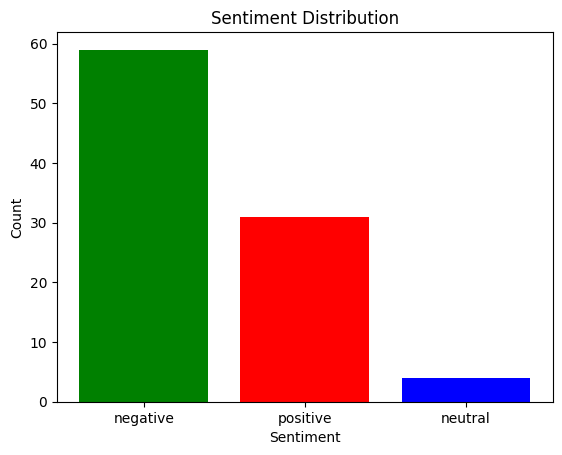

In [ ]:
# Visualize the distribution of sentiment labels
def plot_sentiment_distribution(labels):
    counts = Counter(labels)
    labels, values = zip(*counts.items())
    plt.bar(labels, values, color=['green', 'red', 'blue'])
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiment Distribution")
    plt.savefig('sentiment_distribution.png')  # Save the chart
    plt.show()

plot_sentiment_distribution(sentiment_labels)


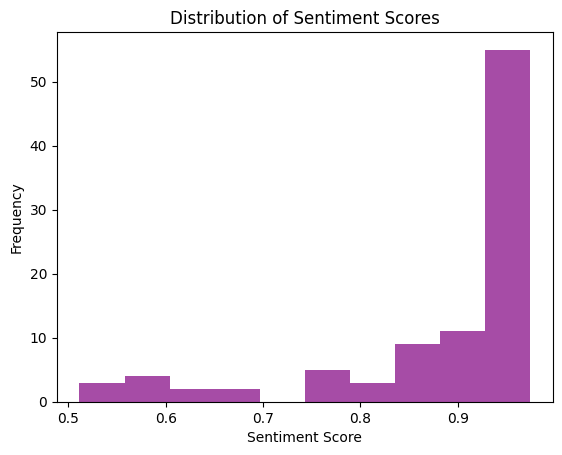

In [ ]:
# Visualize the distribution of sentiment scores
def plot_sentiment_scores(scores):
    plt.hist(scores, bins=10, color='purple', alpha=0.7)
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sentiment Scores")
    plt.savefig('sentiment_scores.png')  # Save the chart
    plt.show()

plot_sentiment_scores(sentiment_scores)


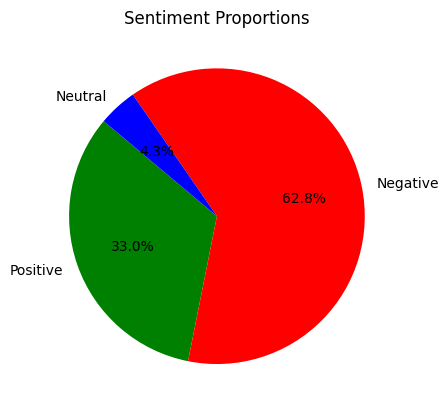

In [ ]:
# Pie chart for sentiment proportions
labels = ['Positive', 'Negative', 'Neutral']
sizes = [num_positive, num_negative, num_neutral]
colors = ['green', 'red', 'blue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Sentiment Proportions")
plt.savefig('sentiment_proportions.png')  # Save the chart
plt.show()


In [ ]:
# Topic extraction from articles using TF-IDF
try:
    tfidf = TfidfVectorizer(max_features=10)
    features = tfidf.fit_transform(unique_articles)
    print("Top Topics:", tfidf.get_feature_names_out())
except ValueError as e:
    print("Error in topic extraction:", e)


Top Topics: ['after' 'and' 'ap' 'as' 'for' 'in' 'of' 'on' 'the' 'to']


In [ ]:
# Summarize the articles using T5
summarizer_model_name = "t5-small"
summarizer_tokenizer = T5Tokenizer.from_pretrained(summarizer_model_name)
summarizer_model = T5ForConditionalGeneration.from_pretrained(summarizer_model_name)

for article in unique_articles:
    article = "summarize: " + article
    inputs = summarizer_tokenizer.encode(article, return_tensors="pt", max_length=512, truncation=True)
    outputs = summarizer_model.generate(
        inputs,
        max_length=50,
        min_length=15,
        length_penalty=2.0,
        num_beams=5,
        early_stopping=True
    )
    summary = summarizer_tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Summary:", summary)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Summary: the S&P 500 was virtually unchanged, a day after pulling back from its latest all-time high. the Dow Jones Industrial Average fell 139 points, or 0.3%, as of 9:35 a.m. Eastern
Summary: shares mixed in Asia, with Chinese shares leading gains. the yen surged against the u.s. dollar. the dollar fell to 151.59 yen.
Summary: stock markets fall in Europe and are mixed on Wall Street. investors retreat as fears of escalation of war against Ukraine prompted investors to retreat.
Summary: the S&P 500 was down 0.1% in the early going Wednesday. losses for Nvidia and Microsoft helped pull the index lower. Dell sank after reporting revenue that fell shy of forecasts.
Summary: world shares started out the week mixed after u.s. stocks fell to their worst loss since election day. the S&P 500 contract up less than 0.1% and that for the Dow Jones Industrial Average 0.1% lower. speculation
Summary: DAX lost 0.5% to 19,196.97 while the CAC 40 in Paris shed 1.2% to 7,109.24. FTSE 100 edged 0.1% h

In [ ]:
# Save predictions to a .tsv file
df = pd.DataFrame(article_predictions, columns=["Article", "Sentiment"])
df.to_csv('article_predictions.tsv', sep='\t', index=False)


In [ ]:
# Test data and corresponding labels for evaluation

test_dataset = pd.read_csv('all-data.csv', encoding='latin-1')
test_dataset.columns = ['label', 'text']
test_dataset = test_dataset.head(1000)

test_data = test_dataset['text'].tolist()
test_labels = test_dataset['label'].tolist()

# Predictions from the model
predicted_labels = [nlp(text)[0]['label'] for text in test_data]


In [ ]:
from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
all_words = ' '.join(test_data)

all_words = re.sub(r'[^a-z\s]', '', all_words)

all_words = all_words.split()

filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)
most_common_word, most_common_count = word_counts.most_common(1)[0]

print(most_common_word)
print(most_common_count)

mn
229


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Evaluate performance on test data
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.903
Precision: 0.9012674752217006
Recall: 0.903
F1 Score: 0.8999712765181891


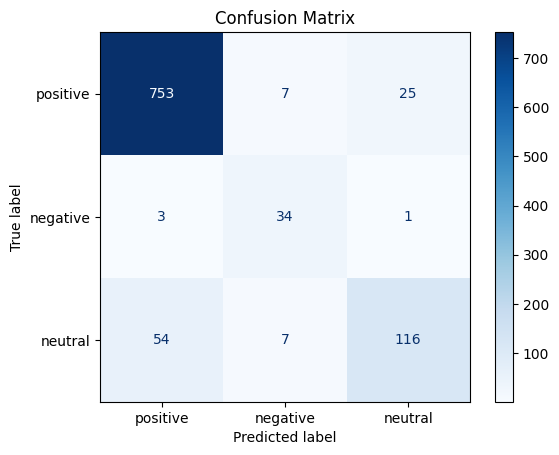

Classification Report:
               precision    recall  f1-score   support

    positive       0.93      0.96      0.94       785
    negative       0.71      0.89      0.79        38
     neutral       0.82      0.66      0.73       177

    accuracy                           0.90      1000
   macro avg       0.82      0.84      0.82      1000
weighted avg       0.90      0.90      0.90      1000



In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=["positive", "negative", "neutral"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["positive", "negative", "neutral"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')  # Save the chart
plt.show()

# Classification Report
report = classification_report(test_labels, predicted_labels, labels=["positive", "negative", "neutral"])
print("Classification Report:\n", report)


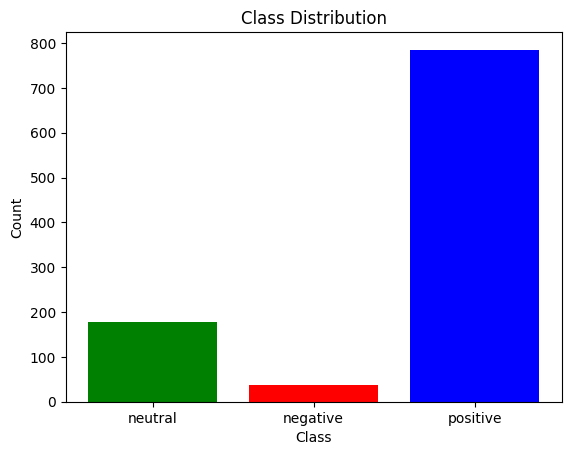

In [ ]:
# Plot the distribution of the classes in test data
def plot_class_distribution(labels):
    counts = Counter(labels)
    labels, values = zip(*counts.items())
    plt.bar(labels, values, color=['green', 'red', 'blue'])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.savefig('class_distribution.png')  # Save the chart
    plt.show()

plot_class_distribution(test_labels)


In [ ]:
# Cross-validation with RandomForestClassifier
# Cross-validation with RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(test_data, test_labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Perform cross-validation with the vectorized training data
cross_val_scores = cross_val_score(RandomForestClassifier(), X_train_vec, y_train, cv=5)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean Cross-validation score: {np.mean(cross_val_scores)}")


Cross-validation scores: [0.78125 0.775   0.7875  0.7875  0.79375]
Mean Cross-validation score: 0.7849999999999999
